## <img src="assets/header_notebook.jpg" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Ocean subgrid parameterizations in an idealized model using machine learning</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [2]:
# -----------------
#     Librairies
# -----------------
#
# --------- Standard ---------
import os
import sys
import json
import glob
import math
import torch
import random
import fsspec
import matplotlib
import fourierflow
import numpy                   as np
import pandas                  as pd
import xarray                  as xr
import seaborn                 as sns
import matplotlib.pyplot       as plt
import matplotlib.gridspec     as gridspec

from matplotlib.colorbar     import Colorbar
from argparse                import ArgumentParser
from scipy.stats             import gaussian_kde
from torch.utils.tensorboard import SummaryWriter

# --------- PYQG ---------
import pyqg
import pyqg.diagnostic_tools
from   pyqg.diagnostic_tools import calc_ispec         as _calc_ispec
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening

calc_ispec = lambda *args, **kwargs: _calc_ispec(*args, averaging = False, truncate = False, **kwargs)

# --------- PYQG Benchmark ---------
from pyqg_parameterization_benchmarks.utils             import *
from pyqg_parameterization_benchmarks.utils_TFE         import *
from pyqg_parameterization_benchmarks.plots_TFE         import *
from pyqg_parameterization_benchmarks.configurations    import *
from pyqg_parameterization_benchmarks.online_metrics    import diagnostic_differences, diagnostic_similarities
from pyqg_parameterization_benchmarks.neural_networks   import NN_Parameterization, NN_Parameterization_Handler
from pyqg_parameterization_benchmarks.nn_analytical     import BackscatterBiharmonic, Smagorinsky, HybridSymbolic
from pyqg_parameterization_benchmarks.nn_kaskade        import Kaskade
from pyqg_parameterization_benchmarks.nn_fcnn           import FullyCNN
from pyqg_parameterization_benchmarks.nn_fno            import FourierNO
from pyqg_parameterization_benchmarks.nn_ffno           import FactorizedFNO
from pyqg_parameterization_benchmarks.nn_unet           import UNet

# --------- Jupyter ---------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to correct folder
%cd ../src/pyqg_parameterization_benchmarks/

[Errno 2] No such file or directory: '../src/pyqg_parameterization_benchmarks/'
/home/vmangeleer/TFE/pyqg_parameterization_benchmarks/src/pyqg_parameterization_benchmarks


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>OFFLINE</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -----------------
# SCRIPT PARAMETERS
# -----------------
# Information to make the plot
folder_offline    = ["EDDIES_ONLINE"] # /!\
folder_models     = ["__PLOT_DEBUG__"]
memory            = 64
type_sim          = "EDDIES"

# Colors for the plot
colors            = ["#07306b", "#2271b6", "#6bafd7", "#c7dcf0"] 
colors_nn         = ["#522888", "#967bb6", "#cdc7d9"]
color_lr          = ["#dcecc9", "#aedddd", "#43a0c6"]
colors_layers     = ["#0b1d78", "#0069c0", "#008ac5", "#00a9b5", "#00c698", "#1fe074"]

In [ ]:
# ----------------------------------
#              Asserts
# ----------------------------------
# Check if the path of each dataset exist
assert check_datasets_availability(folder_offline), \
    f"Assert: One (or more) of the offline test dataset does not exist, check again the name of the folders"

# Check if there is enough memory allocated to load the datasets
needed_memory = get_datasets_memory(folder_offline  , datasets_type = ["ALR"])

assert math.ceil(needed_memory) < memory , \
    f"Assert: Not enough memory allocated to store the offline test datasets ({math.ceil(needed_memory)} [Gb])"

# Check if the model folder does exist
#assert check_model_folder_availability(folder_models), \
#    f"Assert: The folder containing all the models to be tested does not exist or is empty"

# Check if the baseline folder does exist
assert check_model_folder_availability("/___BASELINE___/"), \
    f"Assert: The folder containing all the baseline models to be tested does not exist or is empty"

# Display information over terminal (1)
section("Loading datasets")

# ----------------------------------
#          Loading datasets
# ----------------------------------
_, _, data_ALR_offline  = load_data(folder_offline, datasets_type = ["ALR"])

# -------------------------------------------------
# ----------------- TO BE REMOVED -----------------
# -------------------------------------------------
a = data_ALR_offline.isel(time = 400)
b = data_ALR_offline.isel(time = 401)
c = data_ALR_offline.isel(time = 402)
d = data_ALR_offline.isel(time = 403)
e = data_ALR_offline.isel(time = 404)
f = data_ALR_offline.isel(time = 405)
data_ALR_offline = xr.concat([a,b,c,d,e], dim='time')
# -------------------------------------------------
# ----------------- TO BE REMOVED -----------------
# -------------------------------------------------

# Display information over terminal (2)
print("\nDone\n")

# ------------------------------------------------------------------
#      Accessing & Loading Trained / Baseline Parameterizations
# ------------------------------------------------------------------
section("Loading parameterizations")

# Name of known parameterizations
whitelist = ["FCNN", "KASKADE", "UNET", "FFNO", "FNO"]

# Stores all the parameterizations as well as their names
parameterizations_models, name_models_final = list(), list()

# Looping over the multiple folders to get parameterizations
for fm in folder_models:

    # Path to baseline and trained models
    path_models   = "../../models/" + fm + "/"
    path_baseline = "../../models/___BASELINE___/"

    # Listing all the models
    name_models_temp   = os.listdir(path_models)
    name_baseline_temp = os.listdir(path_baseline)

    # Post-processed list of models name
    name_baseline_nn, name_models = list(), list()
    
    # Analyzing the models
    for n in name_models_temp:
        for w in whitelist:
            if w in n:
                name_models = name_models + [n]
                break

    # Appending the complete list !
    name_models_final = name_models_final + name_models
    
    # Analyzing the baseline           
    for n in name_baseline_temp:
        for w in whitelist:
            if w in n:
                name_baseline_nn.append(n)

    # Loading Trained / Baseline Parameterizations (1)
    parameterizations_models = parameterizations_models + [NN_Parameterization_Handler(path_models   + n) for n in name_models]
    
# Loading Trained / Baseline Parameterizations (2)
parameterizations_baseline_NN = [NN_Parameterization_Handler(path_baseline + n) for n in name_baseline_nn]
parameterizations_baseline_ANAL = [Smagorinsky(0.15), BackscatterBiharmonic(np.sqrt(0.007), 1.2), HybridSymbolic()]

# Updating list of names ! 
name_models = name_models_final

# --------------------------------------------------------
#             Computing Baseline Predictions
# --------------------------------------------------------
print("Computing predictions NN")

# Computing the predictions
offline_preds_baseline_nn = [p.test_offline(data_ALR_offline) for p in parameterizations_baseline_NN]

# Stores the different R^2 and correlation values measured
r2_z0_nn, r2_z1_nn, corr_z0_nn, corr_z1_nn = list(), list(), list(), list()
    
for offline_pred, n in zip(offline_preds_baseline_nn, name_baseline_nn):
    
    # Stores temporarily the different R^2 and correlation values measured
    r2_z0_pred_nn, r2_z1_pred_nn, corr_z0_pred_nn, corr_z1_pred_nn = list(), list(), list(), list()

    # Determine the type of target predicted by the parameterization
    target_type = list()

    if "q_subgrid_forcing" in n:
        target_type = ["q_subgrid_forcing"]
    elif "q_forcing_total" in n:
        target_type = ["q_forcing_total"]
    elif "q_fluxes"        in n:
        target_type = ["uq_subgrid_flux", "vq_subgrid_flux"]
    else:
        raise Exception("ERROR (Offline.py), unknown target type")
            
    for i, t in enumerate(target_type):

        # Computing results
        corr_z0_pred_nn.append(offline_pred[f"{t}_spatial_correlation"].isel(lev = 0))
        corr_z1_pred_nn.append(offline_pred[f"{t}_spatial_correlation"].isel(lev = 1))
        r2_z0_pred_nn.append(  offline_pred[f"{t}_spatial_skill"].isel(      lev = 0))
        r2_z1_pred_nn.append(  offline_pred[f"{t}_spatial_skill"].isel(      lev = 1))

        # If fluxes, skipping to compute mean !
        if len(target_type) == 2 and i == 0:
            continue

        # Updating color map
        cmap_color = "inferno"
        
        # Correlation z = 0
        corr_z0_nn.append(imshow_offline(corr_z0_pred_nn, cmap_color = cmap_color))

        # Correlation z = 1
        corr_z1_nn.append(imshow_offline(corr_z1_pred_nn, cmap_color = cmap_color))

        # RMSE z = 0
        r2_z0_nn.append(imshow_offline(r2_z0_pred_nn, cmap_color = cmap_color))

        # RMSE z = 1
        r2_z1_nn.append(imshow_offline(r2_z1_pred_nn, cmap_color = cmap_color))
                    
# Metrics transformed into pandas dataframe for ease of making comparison plot
metrics_nn = pd.DataFrame({
    "Model"     : beautify_model_names(name_baseline_nn),
    "Model_raw" : name_baseline_nn,
    "R2_z0"     : r2_z0_nn,
    "R2_z1"     : r2_z1_nn,
    "corr_z0"   : corr_z0_nn,
    "corr_z1"   : corr_z1_nn,
})

# Metrics conversion to float
metrics_nn['R2_z0']   = metrics_nn['R2_z0'].astype(float)
metrics_nn['R2_z1']   = metrics_nn['R2_z1'].astype(float)
metrics_nn['corr_z0'] = metrics_nn['corr_z0'].astype(float)
metrics_nn['corr_z1'] = metrics_nn['corr_z1'].astype(float)

print("Done")
print("--------------------\n   CHECKING   \n--------------------")
print(len(parameterizations_models))
print(len(name_models))
print(len(parameterizations_baseline_NN))
print(len(parameterizations_baseline_ANAL))

# --------------------------------------------------------
#              Computing all the predictions
# --------------------------------------------------------
# Stores the different R^2 and correlation values measured
r2_z0, r2_z1, corr_z0, corr_z1 = list(), list(), list(), list()

# Display information over terminal (4)
print("\nComputing (done)    =")
    
# Analyzing the different models 
for param, name in zip(parameterizations_models, name_models):

    # Computing offline predictions
    offline_pred =  param.test_offline(data_ALR_offline)
    
    # Determine the number of lines needed to make subplot
    lines = sum([1 for n in [name] + name_baseline_nn])
    
    # Used to determine which prediction load for baseline
    b_index = 0
    
    # Comparing model & baseline
    for p, n in zip([param] + parameterizations_baseline_NN, [name] + name_baseline_nn):

        # Computing prediction
        offline_pred =  p.test_offline(data_ALR_offline) if n not in name_baseline_nn else \
                        offline_preds_baseline_nn[b_index]

        # Updating the baseline index
        b_index = b_index if n not in name_baseline_nn else b_index + 1

        # Updating color map
        cmap_color = "inferno" if b_index == 0 else "inferno"

        # Determine the type of target predicted by the parameterization
        target_type = list()

        if "q_subgrid_forcing" in n:
            target_type = ["q_subgrid_forcing"]
        elif "q_forcing_total" in n:
            target_type = ["q_forcing_total"]
        elif "q_fluxes"        in n:
            target_type = ["uq_subgrid_flux", "vq_subgrid_flux"]
        else:
            raise Exception("ERROR (Offline.py), unknown target type")

        # Stores final predictions
        corr_z0_pred, corr_z1_pred, r2_z0_pred, r2_z1_pred = list(), list(), list(), list()
            
        # Plotting
        for i, t in enumerate(target_type):
            
            # Computing results
            corr_z0_pred.append(offline_pred[f"{t}_spatial_correlation"].isel(lev = 0))
            corr_z1_pred.append(offline_pred[f"{t}_spatial_correlation"].isel(lev = 1))
            r2_z0_pred.append(  offline_pred[f"{t}_spatial_skill"].isel(      lev = 0))
            r2_z1_pred.append(  offline_pred[f"{t}_spatial_skill"].isel(      lev = 1))
            
            # If fluxes, skipping to compute mean !
            if len(target_type) == 2 and i == 0:
                continue
            
            # Correlation z = 0
            corr_z0.append(imshow_offline(corr_z0_pred, cmap_color = cmap_color)) if b_index == 0 else \
                            imshow_offline(corr_z0_pred, cmap_color = cmap_color)

            # Correlation z = 1
            corr_z1.append(imshow_offline(corr_z1_pred, cmap_color = cmap_color)) if b_index == 0 else \
                            imshow_offline(corr_z1_pred, cmap_color = cmap_color)

            # RMSE z = 0
            r2_z0.append(imshow_offline(r2_z0_pred, cmap_color = cmap_color)) if b_index == 0 else \
                            imshow_offline(r2_z0_pred, cmap_color = cmap_color)

            # RMSE z = 1
            r2_z1.append(imshow_offline(r2_z1_pred, cmap_color = cmap_color)) if b_index == 0 else \
                            imshow_offline(r2_z1_pred, cmap_color = cmap_color)

    # Display information over terminal (5)
    print("\n                      - " + name)
    
# Metrics transformed into pandas dataframe for ease of making comparison plot
metrics = pd.DataFrame({
    "Model"     : beautify_model_names(name_models),
    "Model_raw" : name_models,
    "R2_z0"     : r2_z0,
    "R2_z1"     : r2_z1,
    "corr_z0"   : corr_z0,
    "corr_z1"   : corr_z1,
})

# Metrics conversion to float
metrics['R2_z0']   = metrics['R2_z0'].astype(float)
metrics['R2_z1']   = metrics['R2_z1'].astype(float)
metrics['corr_z0'] = metrics['corr_z0'].astype(float)
metrics['corr_z1'] = metrics['corr_z1'].astype(float)

# Display information over terminal (6)
print("\n")
section("Result comparaison")

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PHASE 2</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -------------------------------------------------------------------------------------
#                                        PHASE 1 AND 2
# -------------------------------------------------------------------------------------
# Defining categories (BE CAREFULL WITH FNO AND FFNO)
subgrid = ["q_forcing_total", "q_subgrid_forcing", "q_fluxes"]
inputs_ = ["q_to", "q_u_to", "q_v_to", "q_u_v_to"]
models_ = ["FCNN", "-UNET", "-FNO", "FFNO"]

# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(13, 4, wspace = 0.1, hspace = 0.65, figure = fig)
    
# ------------------------------------------------------
#                          CORE
# ------------------------------------------------------
print("GENERATING THE CORE PLOT")
for index_s, s in enumerate(subgrid):
    for index_inp, inp in enumerate(inputs_):
        for model_index, m in enumerate(models_):
            
            # Total index
            tot_index = index_s * 4 + index_inp
            
            # Initialization of the complete row
            for init in range(4):
                
                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])
                
                # Fixing y scale
                ax.set_ylim(bottom = 0, top = 1.3)            
                ax.tick_params(axis = 'y', labelsize = 8)
                        
                # Removing x-labels
                ax.set_xticks([])
                ax.label_outer()
            
            # Looping over all the results
            for i in range(len(metrics["Model"])):
                
                # Retreiving the metric values
                model_name     = metrics["Model"][i]
                model_name_raw = metrics["Model_raw"][i]
                z1             = metrics["R2_z0"][i]
                z2             = metrics["R2_z1"][i]
                rho1           = metrics["corr_z0"][i]
                rho2           = metrics["corr_z1"][i]
            
                # Check if corresponding model (correct line)
                if s in model_name_raw and inp in model_name_raw and m in model_name_raw:
                    
                    print(m, model_name_raw, model_index)
           
                    # Adding all the values in the different column
                    for v, value in enumerate([rho1, rho2, z1, z2]):
                     
                        # Retreiving corresponding plot
                        ax = plt.subplot(gs[tot_index, v])
                        
                        # ------- NEGATIVE VALUE --------
                        if value < 0:
                            bars = ax.bar(model_index, 0.05, color = "black")                  
                        else:
                            bars = ax.bar(model_index, value, color = colors[model_index])
                        
                        # Adding the value on top of the bar
                        if value < -10:
                            value = round(value, 1)
                        else:
                            value = round(value, 2)
                                
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  

# ------------------------------------------------------
#                     BASELINES
# ------------------------------------------------------
print("GENERATING THE BASELINE PLOT")
for init in range(4):

    # Allocating the subplot
    ax = plt.subplot(gs[12, init])

    # Fixing y scale
    ax.set_ylim(bottom = 0, top = 1.3)            
    ax.tick_params(axis = 'y', labelsize = 8)

    # Removing x-labels
    ax.set_xticks([])
    ax.label_outer()
    
    for i in range(len(metrics_nn)):
        
        # Retreiving the metric values
        model_name     = metrics_nn["Model"][i]
        model_name_raw = metrics_nn["Model_raw"][i]
        z1             = metrics_nn["R2_z0"][i]
        z2             = metrics_nn["R2_z1"][i]
        rho1           = metrics_nn["corr_z0"][i]
        rho2           = metrics_nn["corr_z1"][i]
        values         = [rho1, rho2, z1, z2]
        value          = values[init]
        
        # ------- NEGATIVE VALUE --------
        if value < 0:
            bars = ax.bar(i, 0.05, color = "black")                  
        else:
            bars = ax.bar(i, value, color = colors_nn[i])
                                    
        # Adding the value on top of the bar
        if value < -10:
            value = round(value, 1)
        else:
            value = round(value, 2)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  
        
print("SAVING PNG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches='tight')
print("SAVING EPS")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches='tight')
print("SAVING PDF")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches='tight')
print("SAVING SVG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches='tight')

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PHASE 3</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -------------------------------------------------------------------------------------
#                                        PHASE 3
# -------------------------------------------------------------------------------------
# Defining categories (BE CAREFULL WITH FNO AND FFNO)
nb_samples = ["5000", "10000", "20000"]
inputs_    = ["q_to", "q_u_to", "q_v_to", "q_u_v_to"]
models_    = ["-FCNN", "-UNET", "-FNO", "-FFNO"]

# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(13, 4, wspace = 0.1, hspace = 0.65, figure = fig)
    
# ------------------------------------------------------
#                          CORE
# ------------------------------------------------------
print("GENERATING THE CORE PLOT")
for index_s, s in enumerate(nb_samples):
    for index_inp, inp in enumerate(inputs_):
        for model_index, m in enumerate(models_):
            
            # Total index
            tot_index = index_s * 4 + index_inp
            
            # Initialization of the complete row
            for init in range(4):
                
                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])
                
                # Fixing y scale
                ax.set_ylim(bottom = 0, top = 1.3)            
                ax.tick_params(axis = 'y', labelsize = 8)
                        
                # Removing x-labels
                ax.set_xticks([])
                ax.label_outer()
            
            # Looping over all the results
            for i in range(len(metrics["Model"])):
                
                # Retreiving the metric values
                model_name     = metrics["Model"][i]
                model_name_raw = metrics["Model_raw"][i]
                z1             = metrics["R2_z0"][i]
                z2             = metrics["R2_z1"][i]
                rho1           = metrics["corr_z0"][i]
                rho2           = metrics["corr_z1"][i]

                # Check if corresponding model (correct line)
                if s in model_name_raw and inp in model_name_raw and m in model_name_raw:
                    
                    # Adding all the values in the different column
                    for v, value in enumerate([rho1, rho2, z1, z2]):
                     
                        # Retreiving corresponding plot
                        ax = plt.subplot(gs[tot_index, v])
                        
                        # ------- NEGATIVE VALUE --------
                        if value < 0:
                            bars = ax.bar(model_index, 0.05, color = "black")                  
                        else:
                            bars = ax.bar(model_index, value, color = colors[model_index])
                        
                        # Adding the value on top of the bar
                        if value < -10:
                            value = round(value, 1)
                        else:
                            value = round(value, 2)
                                
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  

# ------------------------------------------------------
#                     BASELINES
# ------------------------------------------------------
print("GENERATING THE BASELINE PLOT")
for init in range(4):

    # Allocating the subplot
    ax = plt.subplot(gs[-1, init])

    # Fixing y scale
    ax.set_ylim(bottom = 0, top = 1.3)            
    ax.tick_params(axis = 'y', labelsize = 8)

    # Removing x-labels
    ax.set_xticks([])
    ax.label_outer()
    
    for i in range(len(metrics_nn)):
        
        # Retreiving the metric values
        model_name     = metrics_nn["Model"][i]
        model_name_raw = metrics_nn["Model_raw"][i]
        z1             = metrics_nn["R2_z0"][i]
        z2             = metrics_nn["R2_z1"][i]
        rho1           = metrics_nn["corr_z0"][i]
        rho2           = metrics_nn["corr_z1"][i]
        values         = [rho1, rho2, z1, z2]
        value          = values[init]
        
        # ------- NEGATIVE VALUE --------
        if value < 0:
            bars = ax.bar(i, 0.05, color = "black")                  
        else:
            bars = ax.bar(i, value, color = colors_nn[i])
                                    
        # Adding the value on top of the bar
        if value < -10:
            value = round(value, 1)
        else:
            value = round(value, 2)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  
        
print("SAVING PNG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches='tight')
print("SAVING EPS")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches='tight')
print("SAVING PDF")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches='tight')
print("SAVING SVG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches='tight')

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PHASE 4</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -------------------------------------------------------------------------------------
#                                        PHASE 4
# -------------------------------------------------------------------------------------
# Defining categories (BE CAREFULL WITH FNO AND FFNO)
nb_samples = ["5000", "10000", "20000", "40000"]
inputs_    = ["q_to", "q_u_to", "q_v_to", "q_u_v_to"]
models_    = ["-FCNN", "-UNET", "-FNO", "FFNO"]

# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(17, 4, wspace = 0.1, hspace = 0.25, figure = fig)
    
# ------------------------------------------------------
#                          CORE
# ------------------------------------------------------
print("GENERATING THE CORE PLOT")
for index_s, s in enumerate(nb_samples):
    for index_inp, inp in enumerate(inputs_):
        for model_index, m in enumerate(models_):
            
            # Total index
            tot_index = index_s * 4 + index_inp
            
            # Initialization of the complete row
            for init in range(4):
                
                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])
                
                # Fixing y scale
                ax.set_ylim(bottom = 0, top = 1.4)            
                ax.tick_params(axis = 'y', labelsize = 8)
                        
                # Removing x-labels
                ax.set_xticks([])
                ax.label_outer()
            
            # Looping over all the results
            for i in range(len(metrics["Model"])):
                
                # Retreiving the metric values
                model_name     = metrics["Model"][i]
                model_name_raw = metrics["Model_raw"][i]
                z1             = metrics["R2_z0"][i]
                z2             = metrics["R2_z1"][i]
                rho1           = metrics["corr_z0"][i]
                rho2           = metrics["corr_z1"][i]

                # Check if corresponding model (correct line)
                if s in model_name_raw and inp in model_name_raw and m in model_name_raw:
                    
                    # Adding all the values in the different column
                    for v, value in enumerate([rho1, rho2, z1, z2]):
                     
                        # Retreiving corresponding plot
                        ax = plt.subplot(gs[tot_index, v])
                        
                        # ------- NEGATIVE VALUE --------
                        if value < 0:
                            bars = ax.bar(model_index, 0.05, color = "black")                  
                        else:
                            bars = ax.bar(model_index, value, color = colors[model_index])
                        
                        # Adding the value on top of the bar
                        if value < -10:
                            value = round(value, 1)
                        else:
                            value = round(value, 2)
                                
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  

# ------------------------------------------------------
#                     BASELINES
# ------------------------------------------------------
print("GENERATING THE BASELINE PLOT")
for init in range(4):

    # Allocating the subplot
    ax = plt.subplot(gs[-1, init])

    # Fixing y scale
    ax.set_ylim(bottom = 0, top = 1.4)            
    ax.tick_params(axis = 'y', labelsize = 8)

    # Removing x-labels
    ax.set_xticks([])
    ax.label_outer()
    
    for i in range(len(metrics_nn)):
        
        # Retreiving the metric values
        model_name     = metrics_nn["Model"][i]
        model_name_raw = metrics_nn["Model_raw"][i]
        z1             = metrics_nn["R2_z0"][i]
        z2             = metrics_nn["R2_z1"][i]
        rho1           = metrics_nn["corr_z0"][i]
        rho2           = metrics_nn["corr_z1"][i]
        values         = [rho1, rho2, z1, z2]
        value          = values[init]
        
        # ------- NEGATIVE VALUE --------
        if value < 0:
            bars = ax.bar(i, 0.05, color = "black")                  
        else:
            bars = ax.bar(i, value, color = colors_nn[i])
                                    
        # Adding the value on top of the bar
        if value < -10:
            value = round(value, 1)
        else:
            value = round(value, 2)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  
        
print("SAVING PNG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches='tight')
print("SAVING EPS")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches='tight')
print("SAVING PDF")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches='tight')
print("SAVING SVG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches='tight')

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PHASE 5</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
metrics

In [ ]:
# -------------------------------------------------------------------------------------
#                                        PHASE 5
# -------------------------------------------------------------------------------------
# Defining categories (BE CAREFULL WITH FNO AND FFNO)
optimizer     = ["adam", "sgd"]
scheduler     = ["constant", "cosine_warmup_restart", "cosine---", "cyclic", "exponential", "multi_step"]
learning_rate = ["_0.1", "_0.01", "_0.001"]

# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(13, 4, wspace = 0.1, hspace = 0.65, figure = fig)
    
# ------------------------------------------------------
#                          CORE
# ------------------------------------------------------
print("GENERATING THE CORE PLOT")
for index_opt, opt in enumerate(optimizer):
    for index_sch, sch in enumerate(scheduler):
        for index_lr, lr in enumerate(learning_rate):
        
            # Total index
            tot_index = index_opt * 6 + index_sch
            
            # Initialization of the complete row
            for init in range(4):
                
                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])
                
                # Fixing y scale
                ax.set_ylim(bottom = 0, top = 1.4)            
                ax.tick_params(axis = 'y', labelsize = 8)
                        
                # Removing x-labels
                ax.set_xticks([])
                ax.label_outer()
            
            # Looping over all the results
            for i in range(len(metrics["Model"])):
                
                # Retreiving the metric values
                model_name     = metrics["Model"][i]
                model_name_raw = metrics["Model_raw"][i]
                z1             = metrics["R2_z0"][i]
                z2             = metrics["R2_z1"][i]
                rho1           = metrics["corr_z0"][i]
                rho2           = metrics["corr_z1"][i]

                # Check if corresponding model (correct line)
                if lr in model_name_raw and sch in model_name_raw and opt in model_name_raw:
                
                    
                    # Adding all the values in the different column
                    for v, value in enumerate([rho1, rho2, z1, z2]):
                     
                        # Retreiving corresponding plot
                        ax = plt.subplot(gs[tot_index, v])
                        
                        # ------- NEGATIVE VALUE --------
                        if value < 0 or value > 10 or math.isnan(value):
                            bars = ax.bar(index_lr, 0.05, color = "black")                  
                        else:
                            bars = ax.bar(index_lr, value, color = color_lr[index_lr])
                        
                        # Adding the value on top of the bar
                        if value < -10:
                            value =  round(value, 1)
                        if value < -100 or value > 100 or math.isnan(value):
                            value = "NaN"
                        else:
                            value = round(value, 2)
                                
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  

# ------------------------------------------------------
#                     BASELINES
# ------------------------------------------------------
print("GENERATING THE BASELINE PLOT")
for init in range(4):

    # Allocating the subplot
    ax = plt.subplot(gs[-1, init])

    # Fixing y scale
    ax.set_ylim(bottom = 0, top = 1.4)            
    ax.tick_params(axis = 'y', labelsize = 8)

    # Removing x-labels
    ax.set_xticks([])
    ax.label_outer()
    
    for i in range(len(metrics_nn)):
        
        # Retreiving the metric values
        model_name     = metrics_nn["Model"][i]
        model_name_raw = metrics_nn["Model_raw"][i]
        z1             = metrics_nn["R2_z0"][i]
        z2             = metrics_nn["R2_z1"][i]
        rho1           = metrics_nn["corr_z0"][i]
        rho2           = metrics_nn["corr_z1"][i]
        values         = [rho1, rho2, z1, z2]
        value          = values[init]
        
        # ------- NEGATIVE VALUE --------
        if value < 0:
            bars = ax.bar(i, 0.05, color = "black")                  
        else:
            bars = ax.bar(i, value, color = colors_nn[i])
                                    
        # Adding the value on top of the bar
        if value < -10:
            value =  round(value, 1)
        if value < -100 or value > 100 or math.isnan(value):
            value = "NaN"
        else:
            value = round(value, 2)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
            textcoords="offset points", ha='center', va='bottom', fontsize = 9)  

print("SAVING PNG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches='tight')
print("SAVING EPS")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches='tight')
print("SAVING PDF")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches='tight')
print("SAVING SVG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches='tight')

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>MAKE THE LEGEND</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

<Figure size 1200x2000 with 0 Axes>

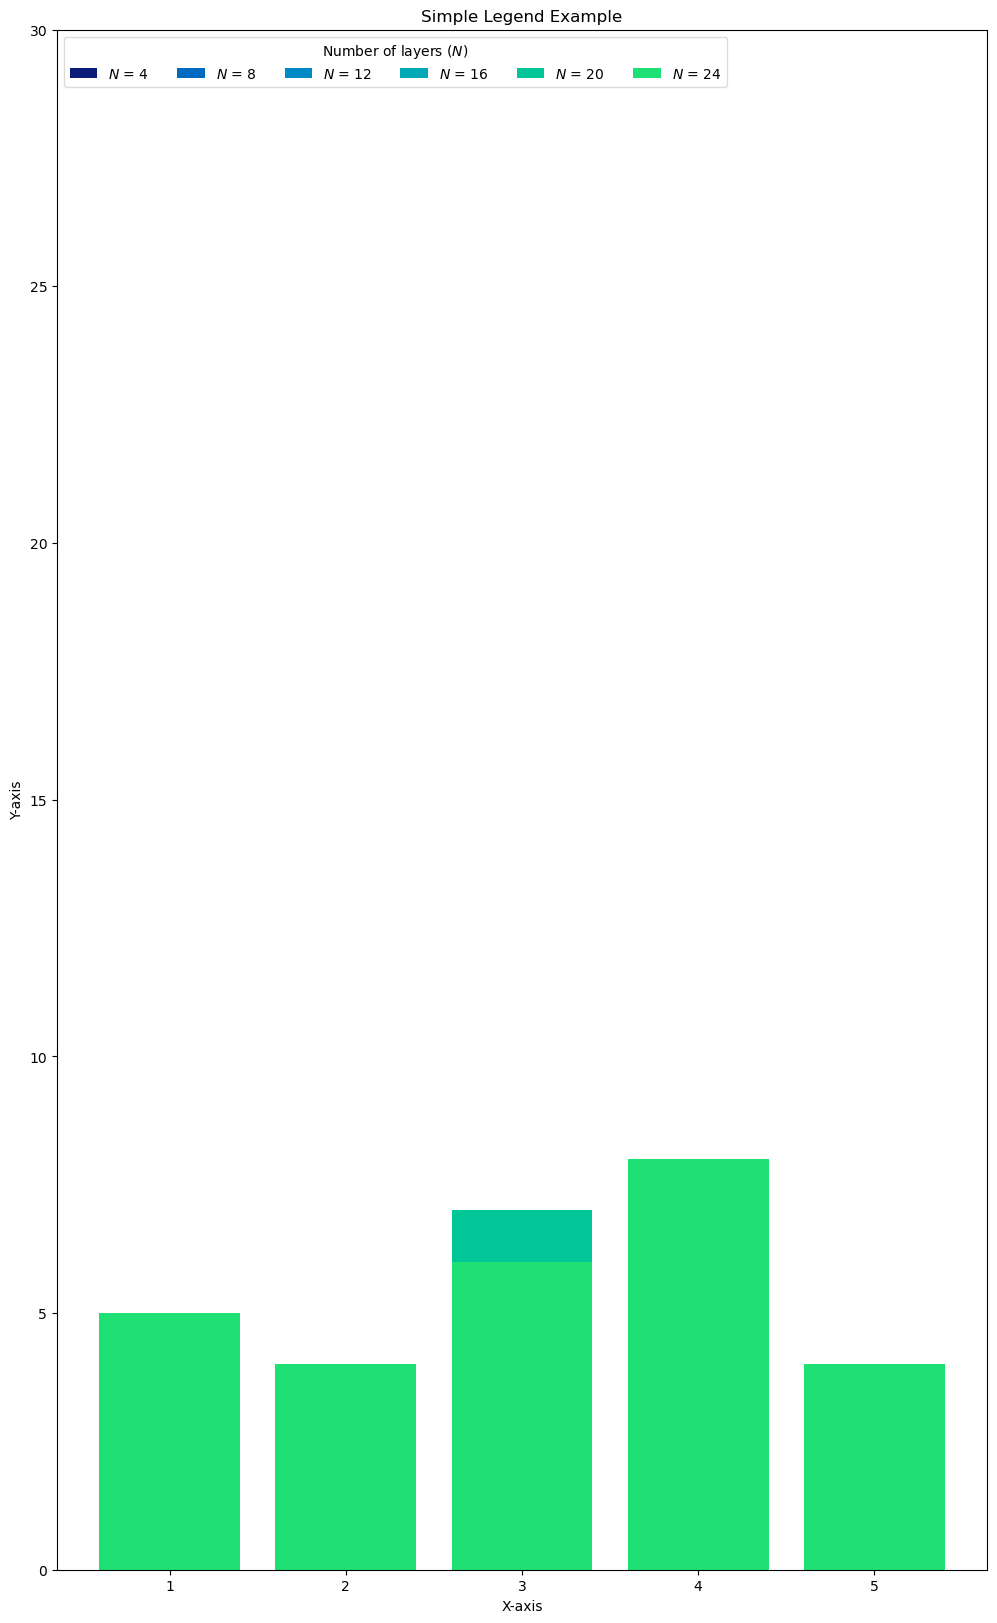

In [23]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]
y2 = [1, 3, 5, 7, 9]
y1 = [5, 4, 6, 8, 4]
y2 = [1, 3, 7, 7, 2]

fig = plt.figure(figsize = (12, 20))

colors_layers     = ["#0b1d78", "#0069c0", "#008ac5", "#00a9b5", "#00c698", "#1fe074"]
colors_nn         = ["#522888", "#967bb6", "#cdc7d9"]
color_lr          = ["#dcecc9", "#aedddd", "#43a0c6"]



nb_layers = [4, 8, 12, 16, 20, 24]

fig = plt.figure(figsize = (12, 20))

# Create a plot
plt.bar(x, y1, label=r'$N$ = 4', color = colors_layers[0])
plt.bar(x, y2, label=r'$N$ = 8', color = colors_layers[1])
plt.bar(x, y1, label=r'$N$ = 12', color = colors_layers[2])
plt.bar(x, y1, label=r'$N$ = 16', color = colors_layers[3])
plt.bar(x, y2, label=r'$N$ = 20', color = colors_layers[4])
plt.bar(x, y1, label=r'$N$ = 24', color = colors_layers[5])

# Add a legend with customizable parameters
plt.legend(
    loc='upper left',      # Location of the legend (options: 'upper', 'lower', 'center', etc.)
    fontsize='medium',    # Font size of the legend labels
    shadow=False,          # Display shadow behind the legend
    frameon=True,         # Display a border around the legend
    framealpha=0.7,       # Transparency of the legend border
    fancybox=True,         # Use rounded corners for the legend border
    ncol=6,
    title=r"Number of layers ($N$)"
)

# Add labels and title
plt.xlabel('X-axis')
plt.ylim([0, 30])
plt.ylabel('Y-axis')
plt.title('Simple Legend Example')

# Show the plot
plt.savefig("PHASE5.svg", bbox_inches='tight')
plt.show()

<Figure size 1200x2000 with 0 Axes>

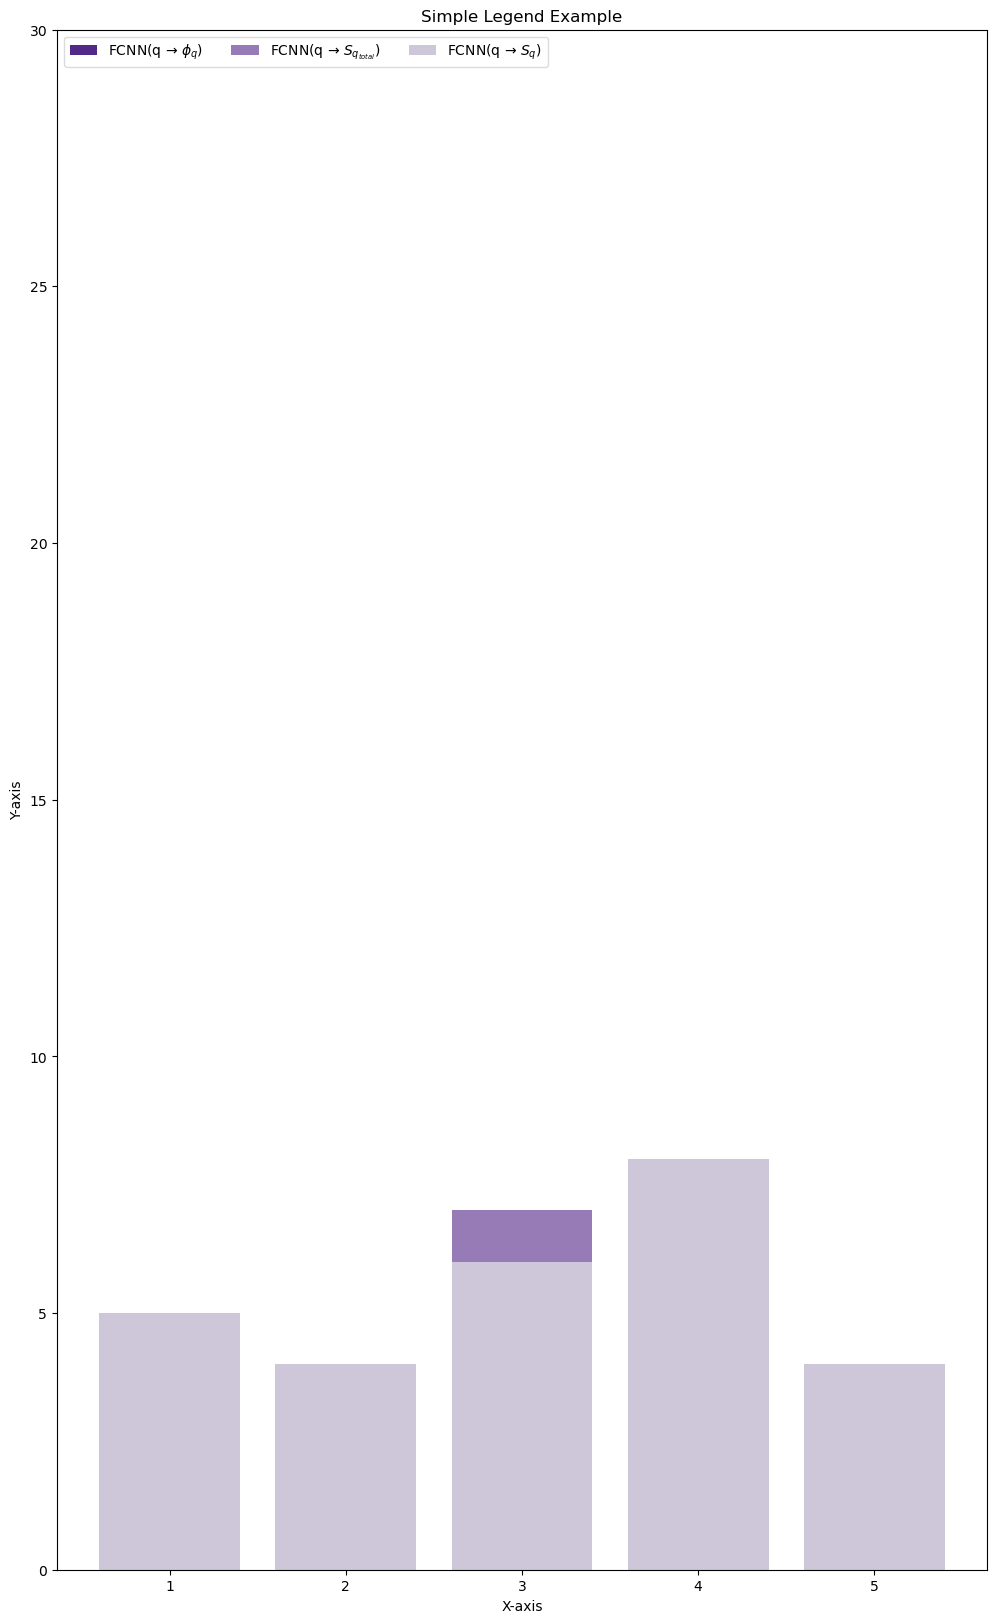

In [5]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]
y2 = [1, 3, 5, 7, 9]
y1 = [5, 4, 6, 8, 4]
y2 = [1, 3, 7, 7, 2]

fig = plt.figure(figsize = (12, 20))

colors_layers     = ["#0b1d78", "#0069c0", "#008ac5", "#00a9b5", "#00c698", "#1fe074"]
colors_nn         = ["#522888", "#967bb6", "#cdc7d9"]
color_lr          = ["#dcecc9", "#aedddd", "#43a0c6"]



nb_layers = [4, 8, 12, 16, 20, 24]

fig = plt.figure(figsize = (12, 20))

# Create a plot
#plt.bar(x, y1, label=r'$\gamma_{LR}$ = 0.1',   color = color_lr[0])
plt.bar(x, y1, label=r"FCNN(q → $\phi_{q}$)", color = colors_nn[0])
#plt.bar(x, y2, label=r'$\gamma_{LR}$ = 0.01',  color = color_lr[1])
plt.bar(x, y2, label=r"FCNN(q → $S_{q_{total}}$)", color = colors_nn[1])
#plt.bar(x, y1, label=r'$\gamma_{LR}$ = 0.001', color = color_lr[2])
plt.bar(x, y1, label=r"FCNN(q → $S_{q}$)", color = colors_nn[2])
            
# Add a legend with customizable parameters
plt.legend(
    loc='upper left',      # Location of the legend (options: 'upper', 'lower', 'center', etc.)
    fontsize='medium',    # Font size of the legend labels
    shadow=False,          # Display shadow behind the legend
    frameon=True,         # Display a border around the legend
    framealpha=0.7,       # Transparency of the legend border
    fancybox=True,         # Use rounded corners for the legend border
    ncol=3,
)

# Add labels and title
plt.xlabel('X-axis')
plt.ylim([0, 30])
plt.ylabel('Y-axis')
plt.title('Simple Legend Example')

# Show the plot
plt.savefig("NEW_LEGEND2.svg", bbox_inches='tight')
plt.show()

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PHASE 6 - High pass</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
metrics

In [ ]:
# ------- FUNCTIONS ---------
def get_all_config_numbers(model_names):
    
    # Stores the list of congifurations
    configs = list()
    
    # Looping over all the models
    for m in model_names:
        
        # Looping over all possible configurations
        for j in range(131):

            # Current index
            i = 130 - j

            # Creation of config identificator
            config_identificator = f"C{str(i)}-"
            
            # Checking
            if config_identificator in m:
                configs.append(i)
                
    return configs

def get_config_hyperparameters(config_value):
    
    # Parameters to explore        
    modes_low_pass  = [(0, 8),  (0, 16), (0, 24), (0, 32)]
    modes_pass_band = [(8, 16), (16, 24), (24, 32)]
    modes           = modes_low_pass + modes_pass_band
    width           = [32, 64, 128]
    layers          = [4, 8, 12, 16, 20, 24]
    weights         = [True]   

    # Total number of combinations possible (here 48 in total)
    total_comb = len(modes) * len(width) * len(layers) * len(weights)

    # Keep count of the configuration index
    config_index = 0

    if config_value < total_comb:

        for we in weights:
            for w in width:
                for l in layers:
                    for m in modes:

                        # Configuration is found !
                        if config_index == config_value:
                            return(m, w, l)
                        else:
                            config_index = config_index + 1

GENERATING THE CORE PLOT
GENERATING THE BASELINE PLOT


'\nprint("SAVING PNG")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches=\'tight\')\nprint("SAVING EPS")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches=\'tight\')\nprint("SAVING PDF")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches=\'tight\')\nprint("SAVING SVG")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches=\'tight\')\n'

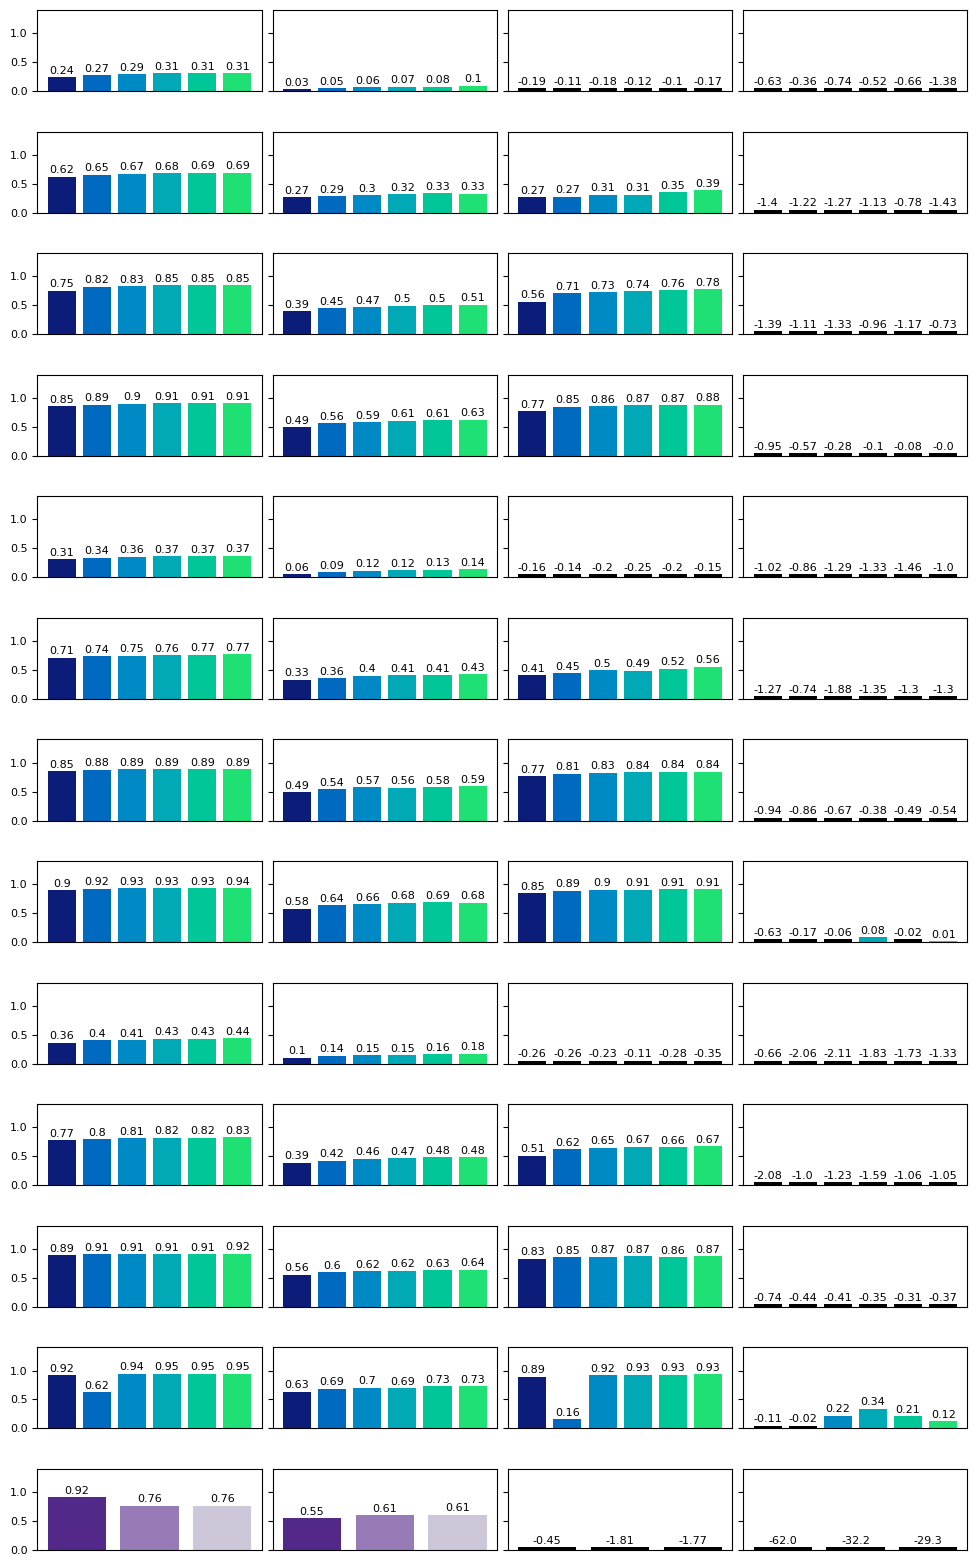

In [47]:
# -------------------------------------------------------------------------------------
#                                    PHASE 6 - PARTIE 1
# -------------------------------------------------------------------------------------
# Defining categories (BE CAREFULL WITH FNO AND FFNO)
width     = [32, 64, 128]
modes     = [(0, 8),  (0, 16), (0, 24), (0, 32)] # LOW PASS
nb_layers = [4, 8, 12, 16, 20, 24]

# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(13, 4, wspace = 0.05, hspace = 0.5, figure = fig)

# ------------------------------------------------------
#                          CORE
# ------------------------------------------------------
print("GENERATING THE CORE PLOT")
for index_width, w in enumerate(width):
    for index_modes, m in enumerate(modes):
        for index_layers, l in enumerate(nb_layers):
        
            # Total index
            tot_index = index_width * 4 + index_modes
            
            # Initialization of the complete row
            for init in range(4):
                
                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])
                
                # Fixing y scale
                ax.set_ylim(bottom = 0, top = 1.4)            
                ax.tick_params(axis = 'y', labelsize = 8)
                        
                # Removing x-labels
                ax.set_xticks([])
                ax.label_outer()
            
            # Looping over all the results
            for i in range(len(metrics["Model"])):
                
                # Retreiving the metric values
                model_name     = metrics["Model"][i]
                model_name_raw = metrics["Model_raw"][i]
                z1             = metrics["R2_z0"][i]
                z2             = metrics["R2_z1"][i]
                rho1           = metrics["corr_z0"][i]
                rho2           = metrics["corr_z1"][i]

                # Retreiving configuration
                curr_mode, curr_width, curr_lay = get_config_hyperparameters(get_all_config_numbers([model_name_raw])[0])
                
                # Check if corresponding model (correct line)
                if w == curr_width and m == curr_mode and l == curr_lay:
                    
                    # Adding all the values in the different column
                    for v, value in enumerate([rho1, rho2, z1, z2]):
                     
                        # Retreiving corresponding plot
                        ax = plt.subplot(gs[tot_index, v])
                        
                        # ------- NEGATIVE VALUE --------
                        if value < 0 or value > 10 or math.isnan(value):
                            bars = ax.bar(index_layers, 0.05, color = "black")                  
                        else:
                            bars = ax.bar(index_layers, value, color = colors_layers[index_layers])
                        
                        # Adding the value on top of the bar
                        if value < -10:
                            value =  round(value, 1)
                        if value < -100 or value > 100 or math.isnan(value):
                            value = "NaN"
                        else:
                            value = round(value, 2)
                                
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 8)  

# ------------------------------------------------------
#                     BASELINES
# ------------------------------------------------------
print("GENERATING THE BASELINE PLOT")
for init in range(4):

    # Allocating the subplot
    ax = plt.subplot(gs[-1, init])

    # Fixing y scale
    ax.set_ylim(bottom = 0, top = 1.4)            
    ax.tick_params(axis = 'y', labelsize = 8)

    # Removing x-labels
    ax.set_xticks([])
    ax.label_outer()
    
    for i in range(len(metrics_nn)):
        
        # Retreiving the metric values
        model_name     = metrics_nn["Model"][i]
        model_name_raw = metrics_nn["Model_raw"][i]
        z1             = metrics_nn["R2_z0"][i]
        z2             = metrics_nn["R2_z1"][i]
        rho1           = metrics_nn["corr_z0"][i]
        rho2           = metrics_nn["corr_z1"][i]
        values         = [rho1, rho2, z1, z2]
        value          = values[init]
        
        # ------- NEGATIVE VALUE --------
        if value < 0:
            bars = ax.bar(i, 0.05, color = "black")                  
        else:
            bars = ax.bar(i, value, color = colors_nn[i])
                                    
        # Adding the value on top of the bar
        if value < -10:
            value =  round(value, 1)
        if value < -100 or value > 100 or math.isnan(value):
            value = "NaN"
        else:
            value = round(value, 2)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
            textcoords="offset points", ha='center', va='bottom', fontsize = 8)  

print("SAVING PNG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches='tight')
print("SAVING EPS")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches='tight')
print("SAVING PDF")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches='tight')
print("SAVING SVG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches='tight')

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PHASE 6 - Cut Band</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

GENERATING THE CORE PLOT
GENERATING THE BASELINE PLOT


'\nprint("SAVING PNG")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches=\'tight\')\nprint("SAVING EPS")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches=\'tight\')\nprint("SAVING PDF")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches=\'tight\')\nprint("SAVING SVG")\nplt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches=\'tight\')\n'

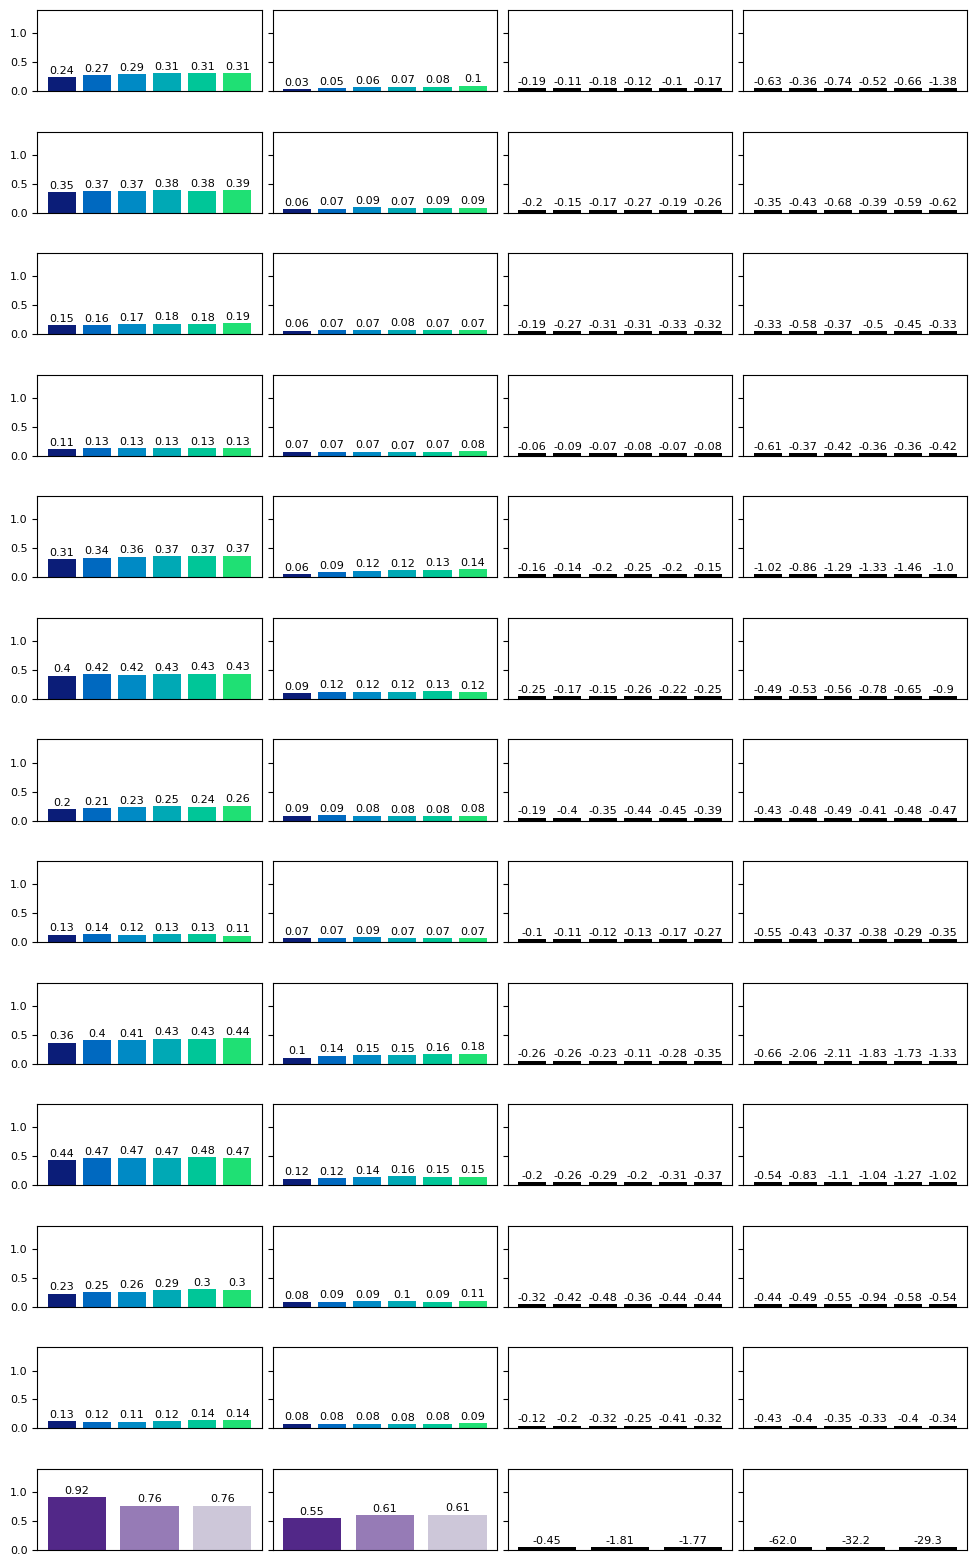

In [48]:
# -------------------------------------------------------------------------------------
#                                    PHASE 6 - PARTIE 2
# -------------------------------------------------------------------------------------
# Defining categories (BE CAREFULL WITH FNO AND FFNO)
width     = [32, 64, 128]
modes     = [(0, 8), (8, 16), (16, 24), (24, 32)]        # PASS BAND
nb_layers = [4, 8, 12, 16, 20, 24]

# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(13, 4, wspace = 0.05, hspace = 0.5, figure = fig)

colors_layers = ["#0b1d78", "#0069c0", "#008ac5", "#00a9b5", "#00c698", "#1fe074"]

# ------------------------------------------------------
#                          CORE
# ------------------------------------------------------
print("GENERATING THE CORE PLOT")
for index_width, w in enumerate(width):
    for index_modes, m in enumerate(modes):
        for index_layers, l in enumerate(nb_layers):
        
            # Total index
            tot_index = index_width * 4 + index_modes
            
            # Initialization of the complete row
            for init in range(4):
                
                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])
                
                # Fixing y scale
                ax.set_ylim(bottom = 0, top = 1.4)            
                ax.tick_params(axis = 'y', labelsize = 8)
                        
                # Removing x-labels
                ax.set_xticks([])
                ax.label_outer()
            
            # Looping over all the results
            for i in range(len(metrics["Model"])):
                
                # Retreiving the metric values
                model_name     = metrics["Model"][i]
                model_name_raw = metrics["Model_raw"][i]
                z1             = metrics["R2_z0"][i]
                z2             = metrics["R2_z1"][i]
                rho1           = metrics["corr_z0"][i]
                rho2           = metrics["corr_z1"][i]

                # Retreiving configuration
                curr_mode, curr_width, curr_lay = get_config_hyperparameters(get_all_config_numbers([model_name_raw])[0])
                
                # Check if corresponding model (correct line)
                if w == curr_width and m == curr_mode and l == curr_lay:
                    
                    # Adding all the values in the different column
                    for v, value in enumerate([rho1, rho2, z1, z2]):
                     
                        # Retreiving corresponding plot
                        ax = plt.subplot(gs[tot_index, v])
                        
                        # ------- NEGATIVE VALUE --------
                        if value < 0 or value > 10 or math.isnan(value):
                            bars = ax.bar(index_layers, 0.05, color = "black")                  
                        else:
                            bars = ax.bar(index_layers, value, color = colors_layers[index_layers])
                        
                        # Adding the value on top of the bar
                        if value < -10:
                            value =  round(value, 1)
                        if value < -100 or value > 100 or math.isnan(value):
                            value = "NaN"
                        else:
                            value = round(value, 2)
                                
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 8)  

# ------------------------------------------------------
#                     BASELINES
# ------------------------------------------------------
print("GENERATING THE BASELINE PLOT")
for init in range(4):

    # Allocating the subplot
    ax = plt.subplot(gs[-1, init])

    # Fixing y scale
    ax.set_ylim(bottom = 0, top = 1.4)            
    ax.tick_params(axis = 'y', labelsize = 8)

    # Removing x-labels
    ax.set_xticks([])
    ax.label_outer()
    
    for i in range(len(metrics_nn)):
        
        # Retreiving the metric values
        model_name     = metrics_nn["Model"][i]
        model_name_raw = metrics_nn["Model_raw"][i]
        z1             = metrics_nn["R2_z0"][i]
        z2             = metrics_nn["R2_z1"][i]
        rho1           = metrics_nn["corr_z0"][i]
        rho2           = metrics_nn["corr_z1"][i]
        values         = [rho1, rho2, z1, z2]
        value          = values[init]
        
        # ------- NEGATIVE VALUE --------
        if value < 0:
            bars = ax.bar(i, 0.05, color = "black")                  
        else:
            bars = ax.bar(i, value, color = colors_nn[i])
                                    
        # Adding the value on top of the bar
        if value < -10:
            value =  round(value, 1)
        if value < -100 or value > 100 or math.isnan(value):
            value = "NaN"
        else:
            value = round(value, 2)

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
            textcoords="offset points", ha='center', va='bottom', fontsize = 8)  

"""
print("SAVING PNG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.png", bbox_inches='tight')
print("SAVING EPS")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.eps", bbox_inches='tight')
print("SAVING PDF")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.pdf", bbox_inches='tight')
print("SAVING SVG")
plt.savefig(f"../../figures/{folder_models[0]}_EVAL_{folder_offline[0]}.svg", bbox_inches='tight')
"""